In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc
import mindspore                 
from mindspore import nn, ops, Tensor
from mindspore.train import Model
import mindspore.numpy as mnp
from mindspore.common.initializer import initializer, XavierUniform
import sys, os, math
from mindcos.operators.derivatives import grad

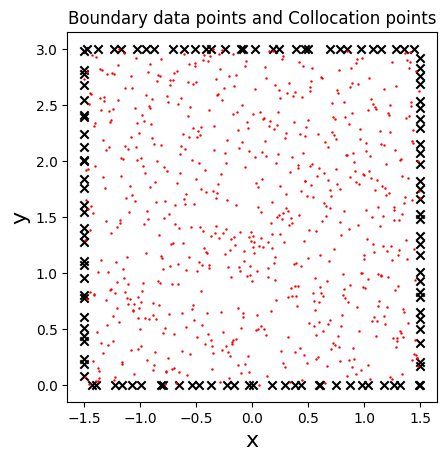

In [2]:
# Arcade structure with different BC on the 4 boundaries ....
# We solve ->  Delta u + lam**2 * u = 0
# where lam is a constant ..............................
# Note that lam**2 * u can also be replaced by a non linear function of u like exp(-u) for example
# but in the latter case, the exact solution is a priori unknown
# ...............................................................................................

### data generation on the boundaries ..... x between -lim1 and lim1
# and y between 0 and lim2 ...................................
n_bc = 4
n_data_per_bc = 30

#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc ,n_data_per_bc , 5])

#
lim1 =3./2
lim2 =3

# Arcade avec conditions de Neumann ....................
#........................................................

for i, j in zip(range(n_bc), [0., 1., 0, 1.]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.) * 1
    #points = np.linspace(0, +1, n_data_per_bc)
    
    if i < 2:
        data[i, :, 0] = j + 0.
        data[i, :, 1] = points - 0.
    else:
        data[i, :, 0] = points + 0.
        data[i, :, 1] = j -0.

data[:, :, 0] = 2*lim1 * data[:, :, 0] - lim1
data[:, :, 1] = data[:, :, 1] * lim2
                
# We define the values of the solution and x and y derivatives on boundaries ...
nn3=3    # mode 3 coefficient
nn1=1   # mode 1 coefficient
nn2 = 2 # mpde 2 ....
lam=0.8   # for the equation ....

# Choose the coefficients (see paper) ........

a3= 1
a2 = 0
a1 = 1

kk3= np.sqrt(nn3**2*np.pi**2/lim2/lim2 - lam**2)
kk1 = np.sqrt(nn1**2*np.pi**2/lim2/lim2 - lam**2)
kk2 = np.sqrt(nn2**2*np.pi**2/lim2/lim2 - lam**2)

def tru(x, y):      
    tru =a3*np.cos(nn3*np.pi*x/lim2)*np.exp(-kk3*y) + a1*np.cos(nn1*np.pi*x/lim2)*np.exp(-kk1*y) + a2 *np.cos(nn2*np.pi*x/lim2)*np.exp(-kk2*y)
    return tru

def truderx(x, y):      
    truderx= -np.pi*nn3/lim2*a3*np.sin(nn3*np.pi*x/lim2)*np.exp(-kk3*y)-np.pi*nn1/lim2*a1*np.sin(nn1*np.pi*x/lim2)*np.exp(-kk1*y)  -np.pi*nn2/lim2*a2*np.sin(nn2*np.pi*x/lim2)*np.exp(-kk2*y)
    return truderx

def trudery(x, y):      
    trudery= -kk3*a3*np.cos(nn3*np.pi*x/lim2)*np.exp(-kk3*y) - kk1*a1*np.cos(nn1*np.pi*x/lim2)*np.exp(-kk1*y)  - kk2*a2*np.cos(nn2*np.pi*x/lim2)*np.exp(-kk2*y)
    return trudery

for j in range(0,n_data_per_bc):    
    # ...........................     
    data[0, j, 2] = tru(-lim1, data[0, j, 1] )
    data[0, j, 3] = truderx(-lim1, data[0, j, 1] )
    data[0, j, 4] = trudery(-lim1, data[0, j, 1] )
           
    #.............................
    data[1, j, 2] = tru(lim1, data[1, j, 1] )
    data[1, j, 3] = truderx(lim1, data[1, j, 1] )
    data[1, j, 4] = trudery(lim1, data[1, j, 1] )

    
for i in range(0,n_data_per_bc):
    # .......................
    data[2, i, 2] = tru(data[2, i, 0], 0 )
    data[2, i, 3] = truderx(data[2, i, 0], 0 )
    data[2, i, 4] = trudery(data[2, i, 0], 0 )

    # .......................  
    data[3, i, 2] = tru(data[3, i, 0], lim2 )
    data[3, i, 3] = truderx(data[3, i, 0], lim2 )
    data[3, i, 4] = trudery(data[3, i, 0], lim2 )
    

data = data.reshape(n_data_per_bc * n_bc, 5)
#

# t_d , t_dx, t_dy are solutions data and associated derivatives wet x and y respectively 
x_d, y_d, t_d , t_dx, t_dy = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]])

#

Nc = 700
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 1 * (colloc -0)

#
colloc[:, 0] = 2*lim1*colloc[:, 0] - lim1
colloc[:, 1] = lim2*colloc[:, 1] 
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

#

plt.title("Boundary data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=2.2, marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
plt.show()
plt.savefig('data.png')
plt.close()
#

x_c, y_c, x_d, y_d, t_d, t_dx, t_dy  =map(lambda x: Tensor(x,dtype=mindspore.float32),
                             [x_c, y_c, x_d, y_d, t_d, t_dx, t_dy ])

In [3]:
class DNN(nn.Cell):
    def __init__(self, in_shape=2, out_shape=1, n_hidden_layers=7, neuron_per_layer=20, actfn="tanh"):
        super(DNN, self).__init__()
        self.layers = nn.SequentialCell()
        # 添加输入层到第一隐藏层
        self.layers.append(nn.Dense(in_shape, neuron_per_layer))
        # 添加激活函数
        if actfn == "tanh":
            self.layers.append(nn.Tanh())
        # 添加剩余隐藏层
        for _ in range(n_hidden_layers - 1):
            self.layers.append(nn.Dense(neuron_per_layer, neuron_per_layer))
            # 添加激活函数
            if actfn == "tanh":
                self.layers.append(nn.Tanh())
        # 添加输出层
        self.layers.append(nn.Dense(neuron_per_layer, out_shape))

    def construct(self, x, y):
        inputs = ops.Concat(axis=1)((x,y))
        t = self.layers(inputs)
        return t


def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=5, neuron_per_layer=20, actfn="tanh"):
    model = DNN(in_shape, out_shape, n_hidden_layers, neuron_per_layer, actfn)
    return model

In [4]:
class Loss(nn.Cell):
    def __init__(self):
        super(Loss, self).__init__()

    def mse(self, u, t):
        return ops.ReduceMean()(ops.Square()(u-t))

    def pde_loss(self, model, x_c, y_c):
        x = x_c
        y = y_c
        '''
        du_dx_fn = grad(model, 0, 0)
        du_dy_fn = grad(model, 0, 1)
        du2_dx2_fn = grad(du_dx_fn, 0, 0)
        du2_dy2_fn = grad(du_dy_fn, 0, 1)
        du_dx = du_dx_fn(x, y)
        du2_dx2 = du2_dx2_fn(x, y)
        du_dy = du_dy_fn(x, y)
        du2_dy2 = du2_dy2_fn(x, y)
        '''
        du2_dx2 = grad(grad(model, 0, 0), 0, 0)(x,y)
        du2_dy2 = grad(grad(model, 0, 1), 0, 1)(x,y)
        #F = du2_dx2 + du2_dy2 + lam*lam*ops.exp(-model(x,y))    
        F =  du2_dx2 + du2_dy2 + lam*lam*model(x,y)
        loss = ops.ReduceMean()(ops.Square()(F))
        return loss
        
    def msex1(self, y, y_):
        yr = y.reshape(n_bc, n_data_per_bc)
        yr_ = y_.reshape(n_bc, n_data_per_bc)
        yrr = yr[0,:]
        yrr_= yr_[0,:]        
        retour = ops.ReduceMean()(ops.Square()(yrr-yrr_))
        return retour

    def msex2(self, y, y_):
        yr = y.reshape(n_bc, n_data_per_bc)
        yr_ = y_.reshape(n_bc, n_data_per_bc)
        yrr = yr[1,:]
        yrr_= yr_[1,:]        
        retour = ops.ReduceMean()(ops.Square()(yrr-yrr_))
        return retour

    def msey1(self, y, y_):
        yr = y.reshape(n_bc, n_data_per_bc)
        yr_ = y_.reshape(n_bc, n_data_per_bc)
        yrr = yr[2,:]
        yrr_= yr_[2,:]        
        retour = ops.ReduceMean()(ops.Square()(yrr-yrr_))
        return retour    

    def msey2(self, y, y_):
        yr = y.reshape(n_bc, n_data_per_bc)
        yr_ = y_.reshape(n_bc, n_data_per_bc)
        yrr = yr[3,:]
        yrr_= yr_[3,:]        
        retour = ops.ReduceMean()(ops.Square()(yrr-yrr_))
        return retour    
        
    def construct(self, model, xc, yc, xd, yd, t_d, t_dx, t_dy):
        T_ = model(xd, yd)
        Tderx_ = grad(model, 0, 0)(x_d, y_d)
        Tdery_ = grad(model, 0, 1)(x_d, y_d)
        
        loss_pde = self.pde_loss(model, xc, yc)
        loss_mse = self.msey1(t_d, T_) + self.msey1(t_dy, Tdery_) + self.msey2(t_d, T_) + self.msex1(t_d, T_) + self.msex2(t_d, T_)
        loss = loss_mse + loss_pde
        return loss

In [5]:
network = DNN_builder(2, 1, 7, 20, "tanh")
# 获取所有可训练参数
params = network.trainable_params()

# 使用 XavierUniform 初始化所有可训练参数
for param in params:
    # 使用 XavierUniform 初始化权重
    if 'weight' in param.name:
        param.set_data(initializer(XavierUniform(), param.shape, mindspore.float32))
    # 使用 Zero 初始化偏置
    elif 'bias' in param.name:
        param.set_data(initializer('zeros', param.shape, mindspore.float32))

optimizer = nn.optim.Adam(network.trainable_params(), learning_rate=3e-4)
loss_fn = Loss()
def forward_fn(xc,yc,xd,yd,t_d,t_dx,t_dy):
    loss = loss_fn(network, xc, yc, xd, yd, t_d, t_dx, t_dy)
    return loss


[WARNING] DEVICE(5935,ffff97b5d020,python):2025-08-28-10:44:53.043.106 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:149] CheckVmmDriverVersion] Open file /etc/ascend_install.info failed.
[WARNING] DEVICE(5935,ffff97b5d020,python):2025-08-28-10:44:53.043.180 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:177] CheckVmmDriverVersion] Open file /usr/local/Ascend/driver/version.info failed.


In [6]:
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)
def train_step(xc, yc, xd, yd, t_d, t_dx, t_dy):
    (loss), grads = grad_fn(xc, yc, xd, yd, t_d, t_dx, t_dy)
    optimizer(grads)
    return loss

def train_loop(model, xc, yc, xd, yd, t_d, t_dx, t_dy):
    model.set_train()
    loss = train_step(xc, yc, xd, yd, t_d, t_dx, t_dy)
    return  loss
    
def test_loop(model, xd, yd, t_d, t_dx, t_dy):
    model.set_train(False)
    pred = model(xd, yd)
    loss_test = loss_fn.mse(pred, t_d)
    return loss_test

In [7]:
def plot(network, ep):
    n = 100
    l = 1.
    r = 2*l/(n+1)
    T = np.zeros([n*n, n*n])

    ### plotting
    #plt.figure("", figsize=(16, 8))
    plt.figure("", figsize=(14, 7))
    #
    X = np.linspace(-lim1, lim1, n)
    Y = np.linspace(0., lim2, n)
    X0, Y0 = np.meshgrid(X, Y)
    X = X0.reshape([n*n, 1])
    Y = Y0.reshape([n*n, 1])
    X_T = Tensor(X, dtype=mindspore.float32)
    Y_T = Tensor(Y, dtype=mindspore.float32)

    S = network(X_T,Y_T)
    S = S.numpy().reshape(n, n)

    # True solutions 
    TT=tru(X0,Y0)

    #
    plt.subplot(221)
    plt.pcolormesh(X0, Y0, S, cmap="turbo")
    plt.colorbar(pad=-0.25)
    plt.xlabel("x")
    plt.ylabel("z")
    plt.xlabel("x",fontsize=16)
    plt.ylabel("z",fontsize=16)
    plt.title("PINN solution")
    plt.tight_layout()
    plt.axis("square")
    #
    x = np.linspace(-lim1, lim1, n)
    y = np.linspace(0., lim2, n)
    x, y = np.meshgrid(x, y)
    #
    plt.subplot(222)
    plt.pcolormesh(X0, Y0, S - TT, cmap="turbo")
    #plt.contour(X0, Y0, S,31)
    plt.colorbar(pad=-0.25)
    plt.title(r"PINN error")
    plt.xlabel("x")
    plt.ylabel("z")
    plt.xlabel("x",fontsize=16)
    plt.ylabel("z",fontsize=16)
    plt.xlim(-lim1, lim1)
    plt.ylim(0., lim2)
    plt.tight_layout()
    plt.axis("square")
    
    x = np.linspace(-lim1, lim1, n)
    y = np.linspace(0, lim2, n)
    x, y = np.meshgrid(x, y)

    # True solutions 
    TT=tru(x,y)

    plt.subplot(223)
    plt.pcolormesh(X0, Y0, TT, cmap="turbo")
    plt.colorbar(pad=-0.25)
    plt.xlabel("x")
    plt.ylabel("z")
    plt.xlabel("x",fontsize=16)
    plt.ylabel("z",fontsize=16)
    plt.title("Exact solution")
    plt.tight_layout()
    plt.axis("square")

    #
    plt.subplot(224)
    plt.pcolormesh(x, y, -TT + S, cmap="turbo")
    plt.colorbar(pad=-0.25)
    plt.title("Error")
    plt.xlabel("x",fontsize=16)
    plt.ylabel("z",fontsize=16)
    plt.xlim(-lim1, lim1)
    plt.ylim(0, lim2)
    plt.tight_layout()
    plt.axis("square")
    plt.savefig(f'result_ep{ep}.png')
    plt.close()


In [ ]:
device_target = mindspore.context.get_context("device_target")
print("当前设备目标:", device_target)
loss = 0
epochs = 60000
epoch = 0
loss_values = np.array([]) #total loss
L_values = np.array([]) #loss pde
l_values = np.array([]) #loss mse
lp_values = np.array([]) #未知
log_dir = './log/Helmholtz'
os.makedirs(log_dir, exist_ok=True)
with open(f'{log_dir}/train.log', 'w') as f:
    f.write('\nepoch, loss, time\n')
#
start = time.time()
#
for epoch in range(epochs):    
    loss = train_loop(network, x_c, y_c, x_d, y_d, t_d, t_dx, t_dy)
    if epoch % 1 == 0 or epoch == epochs-1:
        loss_values = np.append(loss_values, loss)
        if epoch%1000==0:
            print(f"Epoch {epoch+1} {loss}, {time.time()-start:.1f}\n-------------------------------")
        with open(f'{log_dir}/train.log', 'a') as f:
                f.write(f'{epoch+1}, {loss}, {time.time()-start:.1f}\n')

    if epoch % 1000==0:
        plot(network, epoch)

end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")

plt.semilogy(loss_values)
plt.legend()
plt.savefig('loss.png')
plt.close()



当前设备目标: Ascend
Epoch 1 6.1563425, 8.7
-------------------------------
Epoch 1001 0.142412, 561.7
-------------------------------
Epoch 2001 0.015718535, 1128.5
-------------------------------
Epoch 3001 0.0074655064, 1716.1
-------------------------------
Epoch 4001 0.0047872392, 2336.8
-------------------------------
Epoch 5001 0.003298986, 2991.9
-------------------------------
Epoch 6001 0.002853513, 3668.9
-------------------------------
Epoch 7001 0.0017786135, 4389.2
-------------------------------
Epoch 8001 0.0013987999, 5161.7
-------------------------------
Epoch 9001 0.0011395139, 5969.1
-------------------------------
Epoch 10001 0.004573415, 6811.4
-------------------------------
Epoch 11001 0.0008003259, 7699.8
-------------------------------
Epoch 12001 0.00068674015, 8623.1
-------------------------------
Epoch 13001 0.0032499973, 9591.6
-------------------------------
Epoch 14001 0.0005163192, 10615.3
-------------------------------
Epoch 15001 0.0017667399, 11666.2
--